In [1]:
suppressPackageStartupMessages({
    library(dplyr)
    library(ggplot2)
    library(ggpmisc)})

In [2]:
pharm_file <- file.path("..","data", "pharmacology_predictions_ERBB2_PIK3CA_KRAS_AKT1_ccle.tsv")
pharm_full_df <- readr::read_tsv(pharm_file)
head(pharm_full_df)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_character(),
  `Num Data` = col_integer(),
  `EC50 (uM)` = col_double(),
  `IC50 (uM)` = col_double(),
  Amax = col_double(),
  ActArea = col_double(),
  AKT1_MUT = col_integer(),
  PIK3CA_MUT = col_integer(),
  KRAS_MUT = col_integer(),
  ERBB2_MUT = col_integer(),
  BRAF_MUT = col_integer(),
  pi3k_status = col_integer(),
  weight = col_double()
)
See spec(...) for full column specifications.


X1,Primary Cell Line Name,Compound,Target,Doses (uM),Activity Data (median),Activity SD,Num Data,FitType,EC50 (uM),⋯,tissue,AKT1_MUT,PIK3CA_MUT,KRAS_MUT,ERBB2_MUT,BRAF_MUT,pi3k_status,weight,sample_name,predictions
A172_CENTRAL_NERVOUS_SYSTEM,A172,AEW541,IGF1R,".0025,.0080,.025,.080,.25,.80,2.53,8","-.27,.084,-2.7,-6.1,-6.3,-6.1,-15,-22","5.84,1.59,2.77,5.89,2.43,3.25,4.54,7.73",8,Sigmoid,8.4196215,⋯,CENTRAL NERVOUS SYSTEM,0,0,0,0,0,0,0.5489741,A172_CENTRAL_NERVOUS_SYSTEM,mutant
A172_CENTRAL_NERVOUS_SYSTEM,A172,Nilotinib,ABL,".0025,.0080,.025,.080,.25,.80,2.53,8","-.75,3.15,9.45,7.81,1.15,4.57,-3.7,-2.1","6.44,3.36,2.34,1.18,1.86,3.21,4.71,6.22",8,Constant,NA,⋯,CENTRAL NERVOUS SYSTEM,0,0,0,0,0,0,0.5489741,A172_CENTRAL_NERVOUS_SYSTEM,mutant
A172_CENTRAL_NERVOUS_SYSTEM,A172,17-AAG,HSP90,".0025,.0080,.025,.080,.25,.80,2.53,8","-4.1,-3.6,-8.3,-13,-49,-67,-67,-71","2.33,.79,1.76,4.40,3.10,2.19,1.71,2.43",8,Sigmoid,0.1794076,⋯,CENTRAL NERVOUS SYSTEM,0,0,0,0,0,0,0.5489741,A172_CENTRAL_NERVOUS_SYSTEM,mutant
A172_CENTRAL_NERVOUS_SYSTEM,A172,PHA-665752,c-MET,".0025,.0080,.025,.080,.25,.80,2.53,8","-11,-.73,3.40,1.00,.26,5.42,7.48,10.4",".86,7.72,2.80,14.1,6.64,2.25,7.98,6.82",8,Linear,NA,⋯,CENTRAL NERVOUS SYSTEM,0,0,0,0,0,0,0.5489741,A172_CENTRAL_NERVOUS_SYSTEM,mutant
A172_CENTRAL_NERVOUS_SYSTEM,A172,Lapatinib,EGFR,".0025,.0080,.025,.080,.25,.80,2.53,8","3.48,1.18,.20,2.58,-4.6,-2.1,-8.0,-4.2",".91,.27,3.61,4.82,4.66,6.00,3.26,8.81",8,Constant,NA,⋯,CENTRAL NERVOUS SYSTEM,0,0,0,0,0,0,0.5489741,A172_CENTRAL_NERVOUS_SYSTEM,mutant
A172_CENTRAL_NERVOUS_SYSTEM,A172,Nutlin-3,MDM2,".0025,.0080,.025,.080,.25,.80,2.53,8","-1.7,-6.0,1.23,-2.8,-3.8,-5.6,-11,-28","3.06,6.86,8.66,2.42,8.39,14.8,13.4,9.02",8,Sigmoid,8.3907196,⋯,CENTRAL NERVOUS SYSTEM,0,0,0,0,0,0,0.5489741,A172_CENTRAL_NERVOUS_SYSTEM,mutant


In [25]:
comp <- as.matrix(pharm_full_df$Compound)
comp <- unique(comp)
comp

AEW541
Nilotinib
17-AAG
PHA-665752
Lapatinib
Nutlin-3
AZD0530
PF2341066
L-685458
ZD-6474
Panobinostat


In [17]:
plot_drug <- function(pharm_df, compound, tissues = NULL, include_braf = FALSE, 
                      facet_tissue = TRUE, se = FALSE) {
  # Output scatter plots with correlations, visualizing drug activity
  # compared to Ras classifier Score
  #
  # Arguments:
  # pharm_df - dataframe of compound activity by cell line with Ras/BRAF status
  # compound - a specific compound to visualize
  # tissues - a list of tissues to consider plotting specifically in facets
  # include_braf - boolean to include BRAF in considering mutation status
  # facet_tissue - boolean of tissues to determine to plot in facet_wrap
  # se - boolean to plot standard error intervals in geom_smooth
  #
  # Output:
  # Scatter plot with correlation information

  pharm_subset_df <- pharm_df[pharm_df$Compound == compound, ]
  if (!is.null(tissues)) {
    pharm_subset_df <- pharm_subset_df %>%
      dplyr::filter(tissue %in% focus_tissues)
  }
  if (include_braf) {
    pharm_subset_df$pi3k_status[pharm_subset_df$BRAF_MUT == 1] <- 1
    legend_label <- "Pi3k/BRAF Status"
  } else {
    legend_label <- "pi3k Status"
  }
  
  if (compound == "AZD6244") {
    compound <- "Selumetinib"
  }

formula <- y ~ x
     p <- ggplot(pharm_subset_df, aes(x = weight, y = ActArea,
                                   color = as.factor(pi3k_status),
                                   fill = as.factor(pi3k_status))) +
    geom_point(alpha = 0.5, size = 2) +
    scale_x_continuous(breaks = c(0, 0.5, 1),
                       limits = c(-0.1, 1.1)) +
    geom_smooth(method = "lm", se = se) +
    geom_segment(aes(x = 0.5, y = -0.1, xend = 0.5, yend = 6),
                 linetype = "dashed", color = "grey") +
    scale_fill_manual(values = c("#377eb8", "#ff7f00"),
                      name = legend_label,
                      breaks = c(0, 1),
                      labels = c("Wild-Type", "Mutant")) +
    scale_color_manual(values = c("#377eb8", "#ff7f00"),
                       name = legend_label,
                       breaks = c(0, 1),
                       labels = c("Wild-Type", "Mutant")) +
    stat_poly_eq(aes(label = paste(..rr.label..)),
                 label.x.npc = 0.17, label.y.npc = 0.92,
                 formula = formula,
                 parse = TRUE, size = 4, na.rm = TRUE,
                 rr.digits = 1) +
    stat_fit_glance(method = "lm", geom = "text",
                    label.x.npc = 0.8, label.y.npc = 0.97,
                    method.args = list(formula = formula), size = 4,
                    aes(label = paste("P = ",
                                      signif(..p.value.., digits = 1),
                                      sep = ""))) +
    xlab("pi3k Classifier Score") +
    ylab("Activity Area") +
    ggtitle(compound, subtitle = "CCLE Response") + 
    theme_bw() +
    theme(axis.text = element_text(size = 12),
          axis.title = element_text(size = 14),
          plot.title = element_text(hjust = 0.5),
          plot.subtitle = element_text(hjust = 0.5))
  
  if (facet_tissue) {
    p <- p + facet_wrap("tissue")
  }
  
  return(p)
}

In [33]:
focus_tissues <- c("CENTRAL NERVOUS SYSTEM", "SKIN", "BREAST", "HAEMATOPOIETIC AND LYMPHOID TISSUE", "LARGE INTESTINE",
                   "LUNG", "OVARY", "PANCREAS", "LIVER")

pdf("/data/vijay/git/pancancer/figures/cell_line/pi3k_gain_all_drug_response.pdf")

sel_fig <- plot_drug(pharm_full_df, "AZD6244", facet_tissue = FALSE, se = TRUE)
sel_fig

p_fig_AEW541 <- plot_drug(pharm_full_df, "AEW541", facet_tissue = FALSE, se = TRUE)
p_fig_AEW541

p_fig_Nilotinib <- plot_drug(pharm_full_df, "Nilotinib", facet_tissue = FALSE, se = TRUE)
p_fig_Nilotinib

p_fig_17 <- plot_drug(pharm_full_df, "17-AAG", facet_tissue = FALSE, se = TRUE)
p_fig_17

p_fig_PHA665752 <- plot_drug(pharm_full_df, "PHA-665752", facet_tissue = FALSE, se = TRUE)
p_fig_PHA665752

p_fig_Lapatinib <- plot_drug(pharm_full_df, "Lapatinib", facet_tissue = FALSE, se = TRUE)
p_fig_Lapatinib

p_fig_Nutlin <- plot_drug(pharm_full_df, "Nutlin-3", facet_tissue = FALSE, se = TRUE)
p_fig_Nutlin

p_fig_AZD0530 <- plot_drug(pharm_full_df, "AZD0530", facet_tissue = FALSE, se = TRUE)
p_fig_AZD0530

p_fig_PF2341066 <- plot_drug(pharm_full_df, "PF2341066", facet_tissue = FALSE, se = TRUE)
p_fig_PF2341066

p_fig_L685458 <- plot_drug(pharm_full_df, "L-685458", facet_tissue = FALSE, se = TRUE)
p_fig_L685458

p_fig_ZD6474 <- plot_drug(pharm_full_df, "ZD-6474", facet_tissue = FALSE, se = TRUE)
p_fig_ZD6474

p_fig_Panobinostat <- plot_drug(pharm_full_df, "Panobinostat", facet_tissue = FALSE, se = TRUE)
p_fig_Panobinostat

p_fig_Sorafenib <- plot_drug(pharm_full_df, "Sorafenib", facet_tissue = FALSE, se = TRUE)
p_fig_Sorafenib

p_fig_Irinotecan <- plot_drug(pharm_full_df, "Irinotecan", facet_tissue = FALSE, se = TRUE)
p_fig_Irinotecan

p_fig_Topotecan <- plot_drug(pharm_full_df, "Topotecan", facet_tissue = FALSE, se = TRUE)
p_fig_Topotecan

p_fig_LBW242 <- plot_drug(pharm_full_df, "LBW242", facet_tissue = FALSE, se = TRUE)
p_fig_LBW242

p_fig_PD0325901 <- plot_drug(pharm_full_df, "PD-0325901", facet_tissue = FALSE, se = TRUE)
p_fig_PD0325901

p_fig_PD0332991 <- plot_drug(pharm_full_df, "PD-0332991", facet_tissue = FALSE, se = TRUE)
p_fig_PD0332991

p_fig_Paclitaxel <- plot_drug(pharm_full_df, "Paclitaxel", facet_tissue = FALSE, se = TRUE)
p_fig_Paclitaxel

p_fig_PLX4720 <- plot_drug(pharm_full_df, "PLX4720", facet_tissue = FALSE, se = TRUE)
p_fig_PLX4720

p_fig_RAF265 <- plot_drug(pharm_full_df, "RAF265", facet_tissue = FALSE, se = TRUE)
p_fig_RAF265

p_fig_TAE684 <- plot_drug(pharm_full_df, "TAE684", facet_tissue = FALSE, se = TRUE)
p_fig_TAE684

p_fig_TKI258 <- plot_drug(pharm_full_df, "TKI258", facet_tissue = FALSE, se = TRUE)
p_fig_TKI258

dev.off()

png 
  2

In [28]:
focus_tissues <- c("CENTRAL NERVOUS SYSTEM", "SKIN", "BREAST", "HAEMATOPOIETIC AND LYMPHOID TISSUE", "LARGE INTESTINE",
                   "LUNG", "OVARY", "PANCREAS", "LIVER")

pdf("/data/vijay/git/pancancer/figures/cell_line/pi3k_gain_braf_all_drug_response.pdf")

sel_fig <- plot_drug(pharm_full_df, "AZD6244", facet_tissue = FALSE, se = TRUE)
sel_fig

p_fig_AEW541 <- plot_drug(pharm_full_df, "AEW541", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_AEW541

p_fig_Nilotinib <- plot_drug(pharm_full_df, "Nilotinib", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_Nilotinib

p_fig_17 <- plot_drug(pharm_full_df, "17-AAG", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_17

p_fig_PHA665752 <- plot_drug(pharm_full_df, "PHA-665752", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_PHA665752

p_fig_Lapatinib <- plot_drug(pharm_full_df, "Lapatinib", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_Lapatinib

p_fig_Nutlin <- plot_drug(pharm_full_df, "Nutlin-3", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_Nutlin

p_fig_AZD0530 <- plot_drug(pharm_full_df, "AZD0530", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_AZD0530

p_fig_PF2341066 <- plot_drug(pharm_full_df, "PF2341066", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_PF2341066

p_fig_L685458 <- plot_drug(pharm_full_df, "L-685458", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_L685458

p_fig_ZD6474 <- plot_drug(pharm_full_df, "ZD-6474", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_ZD6474

p_fig_Panobinostat <- plot_drug(pharm_full_df, "Panobinostat", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_Panobinostat

p_fig_Sorafenib <- plot_drug(pharm_full_df, "Sorafenib", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_Sorafenib

p_fig_Irinotecan <- plot_drug(pharm_full_df, "Irinotecan", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_Irinotecan

p_fig_Topotecan <- plot_drug(pharm_full_df, "Topotecan", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_Topotecan

p_fig_LBW242 <- plot_drug(pharm_full_df, "LBW242", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_LBW242

p_fig_PD0325901 <- plot_drug(pharm_full_df, "PD-0325901", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_PD0325901

p_fig_PD0332991 <- plot_drug(pharm_full_df, "PD-0332991", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_PD0332991

p_fig_Paclitaxel <- plot_drug(pharm_full_df, "Paclitaxel", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_Paclitaxel

p_fig_PLX4720 <- plot_drug(pharm_full_df, "PLX4720", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_PLX4720

p_fig_RAF265 <- plot_drug(pharm_full_df, "RAF265", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_RAF265

p_fig_TAE684 <- plot_drug(pharm_full_df, "TAE684", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_TAE684

p_fig_TKI258 <- plot_drug(pharm_full_df, "TKI258", facet_tissue = FALSE, include_braf = TRUE, se = TRUE)
p_fig_TKI258

dev.off()

png 
  2

In [30]:
focus_tissues <- c("CENTRAL NERVOUS SYSTEM", "SKIN", "BREAST", "HAEMATOPOIETIC AND LYMPHOID TISSUE", "LARGE INTESTINE",
                   "LUNG", "OVARY", "PANCREAS", "LIVER")

pdf("/data/vijay/git/pancancer/figures/cell_line/pi3k_gain_tissue_response.pdf")

sel_fig <- plot_drug(pharm_full_df, "AZD6244",   tissues = focus_tissues)
sel_fig

p_fig_AEW541 <- plot_drug(pharm_full_df, "AEW541", tissues = focus_tissues)
p_fig_AEW541

p_fig_Nilotinib <- plot_drug(pharm_full_df, "Nilotinib",   tissues = focus_tissues)
p_fig_Nilotinib

p_fig_17 <- plot_drug(pharm_full_df, "17-AAG",   tissues = focus_tissues)
p_fig_17

p_fig_PHA665752 <- plot_drug(pharm_full_df, "PHA-665752",   tissues = focus_tissues)
p_fig_PHA665752

p_fig_Lapatinib <- plot_drug(pharm_full_df, "Lapatinib",   tissues = focus_tissues)
p_fig_Lapatinib

p_fig_Nutlin <- plot_drug(pharm_full_df, "Nutlin-3",   tissues = focus_tissues)
p_fig_Nutlin

p_fig_AZD0530 <- plot_drug(pharm_full_df, "AZD0530",   tissues = focus_tissues)
p_fig_AZD0530

p_fig_PF2341066 <- plot_drug(pharm_full_df, "PF2341066",   tissues = focus_tissues)
p_fig_PF2341066

p_fig_L685458 <- plot_drug(pharm_full_df, "L-685458",   tissues = focus_tissues)
p_fig_L685458

p_fig_ZD6474 <- plot_drug(pharm_full_df, "ZD-6474",   tissues = focus_tissues)
p_fig_ZD6474

p_fig_Panobinostat <- plot_drug(pharm_full_df, "Panobinostat",   tissues = focus_tissues)
p_fig_Panobinostat

p_fig_Sorafenib <- plot_drug(pharm_full_df, "Sorafenib",   tissues = focus_tissues)
p_fig_Sorafenib

p_fig_Irinotecan <- plot_drug(pharm_full_df, "Irinotecan",   tissues = focus_tissues)
p_fig_Irinotecan

p_fig_Topotecan <- plot_drug(pharm_full_df, "Topotecan",   tissues = focus_tissues)
p_fig_Topotecan

p_fig_LBW242 <- plot_drug(pharm_full_df, "LBW242",   tissues = focus_tissues)
p_fig_LBW242

p_fig_PD0325901 <- plot_drug(pharm_full_df, "PD-0325901",   tissues = focus_tissues)
p_fig_PD0325901

p_fig_PD0332991 <- plot_drug(pharm_full_df, "PD-0332991",   tissues = focus_tissues)
p_fig_PD0332991

p_fig_Paclitaxel <- plot_drug(pharm_full_df, "Paclitaxel",   tissues = focus_tissues)
p_fig_Paclitaxel

p_fig_PLX4720 <- plot_drug(pharm_full_df, "PLX4720",   tissues = focus_tissues)
p_fig_PLX4720

p_fig_RAF265 <- plot_drug(pharm_full_df, "RAF265",   tissues = focus_tissues)
p_fig_RAF265

p_fig_TAE684 <- plot_drug(pharm_full_df, "TAE684",   tissues = focus_tissues)
p_fig_TAE684

p_fig_TKI258 <- plot_drug(pharm_full_df, "TKI258",   tissues = focus_tissues)
p_fig_TKI258

dev.off()

png 
  2

In [29]:
focus_tissues <- c("CENTRAL NERVOUS SYSTEM", "SKIN", "BREAST", "HAEMATOPOIETIC AND LYMPHOID TISSUE", "LARGE INTESTINE",
                   "LUNG", "OVARY", "PANCREAS", "LIVER")

pdf("/data/vijay/git/pancancer/figures/cell_line/pi3k_gain_braf_tissue_response.pdf")

sel_fig <- plot_drug(pharm_full_df, "AZD6244",   tissues = focus_tissues)
sel_fig

p_fig_AEW541 <- plot_drug(pharm_full_df, "AEW541", include_braf = TRUE, tissues = focus_tissues)
p_fig_AEW541

p_fig_Nilotinib <- plot_drug(pharm_full_df, "Nilotinib",   include_braf = TRUE, tissues = focus_tissues)
p_fig_Nilotinib

p_fig_17 <- plot_drug(pharm_full_df, "17-AAG",   include_braf = TRUE, tissues = focus_tissues)
p_fig_17

p_fig_PHA665752 <- plot_drug(pharm_full_df, "PHA-665752",   include_braf = TRUE, tissues = focus_tissues)
p_fig_PHA665752

p_fig_Lapatinib <- plot_drug(pharm_full_df, "Lapatinib",   include_braf = TRUE, tissues = focus_tissues)
p_fig_Lapatinib

p_fig_Nutlin <- plot_drug(pharm_full_df, "Nutlin-3",   include_braf = TRUE, tissues = focus_tissues)
p_fig_Nutlin

p_fig_AZD0530 <- plot_drug(pharm_full_df, "AZD0530",   include_braf = TRUE, tissues = focus_tissues)
p_fig_AZD0530

p_fig_PF2341066 <- plot_drug(pharm_full_df, "PF2341066",   include_braf = TRUE, tissues = focus_tissues)
p_fig_PF2341066

p_fig_L685458 <- plot_drug(pharm_full_df, "L-685458",   include_braf = TRUE, tissues = focus_tissues)
p_fig_L685458

p_fig_ZD6474 <- plot_drug(pharm_full_df, "ZD-6474",   include_braf = TRUE, tissues = focus_tissues)
p_fig_ZD6474

p_fig_Panobinostat <- plot_drug(pharm_full_df, "Panobinostat",   include_braf = TRUE, tissues = focus_tissues)
p_fig_Panobinostat

p_fig_Sorafenib <- plot_drug(pharm_full_df, "Sorafenib",   include_braf = TRUE, tissues = focus_tissues)
p_fig_Sorafenib

p_fig_Irinotecan <- plot_drug(pharm_full_df, "Irinotecan",   include_braf = TRUE, tissues = focus_tissues)
p_fig_Irinotecan

p_fig_Topotecan <- plot_drug(pharm_full_df, "Topotecan",   include_braf = TRUE, tissues = focus_tissues)
p_fig_Topotecan

p_fig_LBW242 <- plot_drug(pharm_full_df, "LBW242",   include_braf = TRUE, tissues = focus_tissues)
p_fig_LBW242

p_fig_PD0325901 <- plot_drug(pharm_full_df, "PD-0325901",   include_braf = TRUE, tissues = focus_tissues)
p_fig_PD0325901

p_fig_PD0332991 <- plot_drug(pharm_full_df, "PD-0332991",   include_braf = TRUE, tissues = focus_tissues)
p_fig_PD0332991

p_fig_Paclitaxel <- plot_drug(pharm_full_df, "Paclitaxel",   include_braf = TRUE, tissues = focus_tissues)
p_fig_Paclitaxel

p_fig_PLX4720 <- plot_drug(pharm_full_df, "PLX4720",   include_braf = TRUE, tissues = focus_tissues)
p_fig_PLX4720

p_fig_RAF265 <- plot_drug(pharm_full_df, "RAF265",   include_braf = TRUE, tissues = focus_tissues)
p_fig_RAF265

p_fig_TAE684 <- plot_drug(pharm_full_df, "TAE684",   include_braf = TRUE, tissues = focus_tissues)
p_fig_TAE684

p_fig_TKI258 <- plot_drug(pharm_full_df, "TKI258",   include_braf = TRUE, tissues = focus_tissues)
p_fig_TKI258

dev.off()

png 
  2

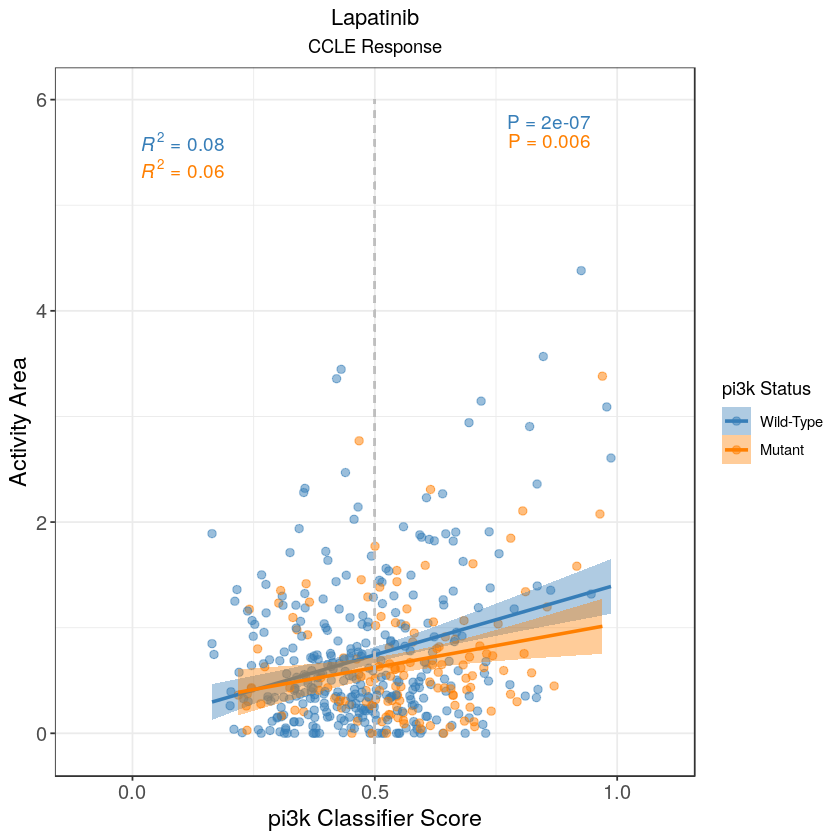

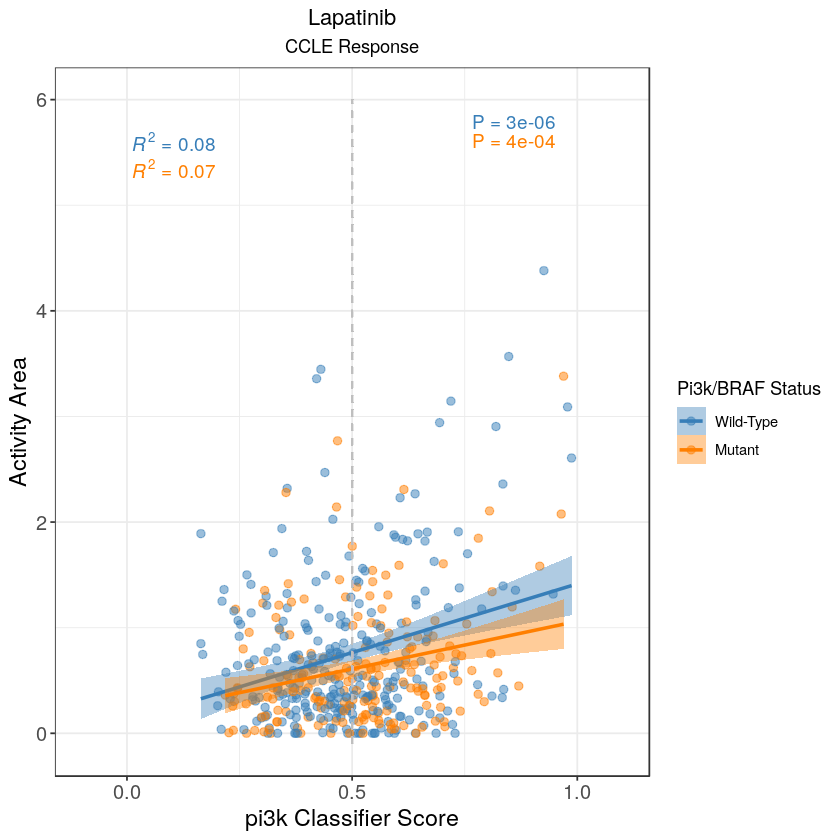

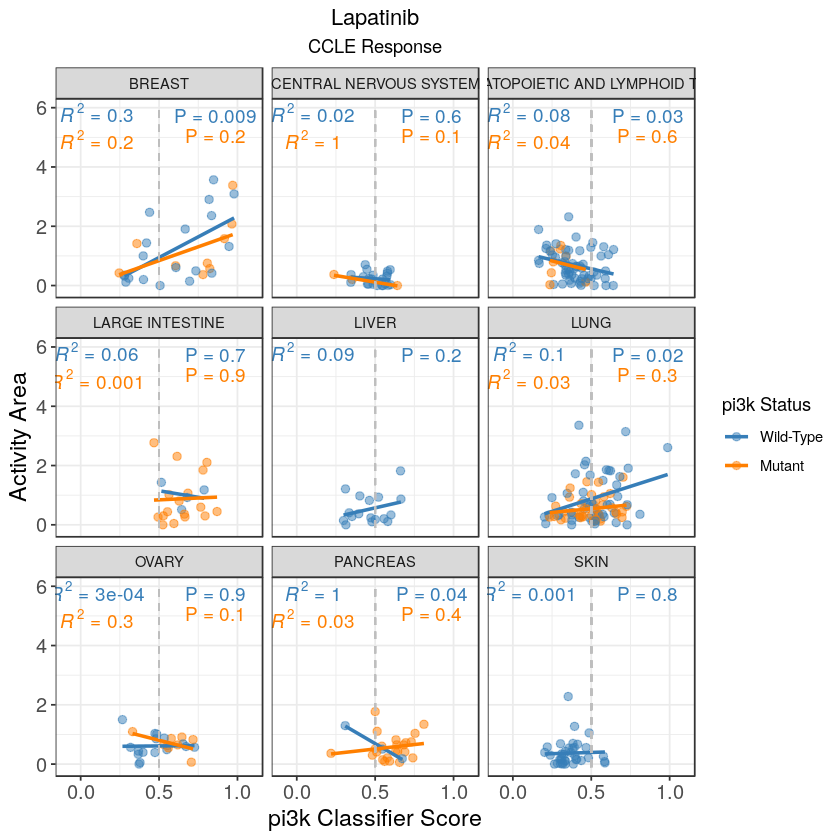

In [6]:
focus_tissues <- c("CENTRAL NERVOUS SYSTEM", "SKIN", "BREAST", "HAEMATOPOIETIC AND LYMPHOID TISSUE", "LARGE INTESTINE",
                   "LUNG", "OVARY", "PANCREAS", "LIVER")

#Plot and output figures
# Selumetinib all tissues - Ras only
sel_fig <- plot_drug(pharm_full_df, "AZD6244", facet_tissue = FALSE, se = TRUE)
#ggplot2::ggsave(selum_file, plot = sel_fig, dpi = 600, height = 4, width = 5.25)
# Selumetinib all tissues - Ras and BRAF
sel_braf_fig <- plot_drug(pharm_full_df, "AZD6244", facet_tissue = FALSE,
                          include_braf = TRUE, se = TRUE)
#ggplot2::ggsave(selum_braf_file, plot = sel_braf_fig, dpi = 600, height = 4,
#                width = 5.25)

# PD-0325901 all tissues - Ras only
p_fig <- plot_drug(pharm_full_df, "Lapatinib", facet_tissue = FALSE, se = TRUE)
#ggplot2::ggsave(pd_file, plot = p_fig, dpi = 600, height = 4,
#                width = 5.25)
p_fig
# PD-0325901 all tissues - Ras and BRAF
p_braf_fig <- plot_drug(pharm_full_df, "Lapatinib", facet_tissue = FALSE,
                        include_braf = TRUE, se = TRUE)
p_braf_fig
#ggplot2::ggsave(pd_braf_file, plot = p_braf_fig, dpi = 600,
#                height = 4.5, width = 8)
# Selumetinib stratified by tissue - Ras only
sel_tis_fig <- plot_drug(pharm_full_df, "AZD6244", tissues = focus_tissues)
#ggplot2::ggsave(selum_tissue_file, plot = sel_tis_fig, dpi = 600,
#                height = 4.5, width = 8)
# Selumetinib stratified by tissue - Ras and BRAF
sel_tis_braf_fig <- plot_drug(pharm_full_df, "AZD6244",
                              tissues = focus_tissues, include_braf = TRUE)
#ggplot2::ggsave(selum_tissue_braf_file, plot = sel_tis_braf_fig, dpi = 600,
#                height = 4.5, width = 8)

# PD-0325901 stratified by tissue - Ras only
p_tis_fig <- plot_drug(pharm_full_df, "Lapatinib", tissues = focus_tissues)
#ggplot2::ggsave(pd_tissue_file, plot = p_tis_fig, dpi = 600,
#                height = 4.5, width = 8)
p_tis_fig
# PD-0325901 stratified by tissue - Ras and BRAF
p_tis_braf_fig <- plot_drug(pharm_full_df, "PD-0325901",
                              tissues = focus_tissues, include_braf = TRUE)
#ggplot2::ggsave(pd_tissue_braf_file, plot = p_tis_braf_fig,
#                dpi = 600, height = 4.5, width = 8)


In [3]:
# Output Files
base_path <- file.path("figures", "cell_line")
selum_file <- file.path(base_path, "selumetinib.pdf")
selum_braf_file <- file.path(base_path, "selumetinib_braf.pdf")
selum_tissue_file <- file.path(base_path, "selumetinib_tissues.pdf")
selum_tissue_braf_file <- file.path(base_path, "selumetinib_tissues_braf.pdf")

In [4]:
pd_file <- file.path(base_path, "pd_0325901.pdf")
pd_braf_file <- file.path(base_path, "pd_0325901_braf.pdf")
pd_tissue_file <- file.path(base_path, "pd_0325901_tissues.pdf")
pd_tissue_braf_file <- file.path(base_path, "pd_0325901_tissues_braf.pdf")